### A/B test

Project aim: to conduct A/B test and evaluate the results of the improved recommendation system.

A - control group (unchanged recommendation system)

B - test group (improved recommendation system)

### Step 1. Obtaining data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# load datasets
orders = pd.read_csv('https://github.com/Artemev-PA/Portfolio/blob/main/A-B_test/datasets/orders.csv?raw=true')
visitors = pd.read_csv('https://github.com/Artemev-PA/Portfolio/blob/main/A-B_test/datasets/visitors.csv?raw=true')

### Step 2. Data preprocessing

In [3]:
def data_preprocessing(df):
    """
    Method that lowers column names, prints first 5 rows of the dataset,
    general info and checks for the duplicates and omitted values
    """
    display(df.head())
    print('Duplicates: ', df.duplicated().sum(), '\n')
    print('Null:\n', df.isna().sum(), '\n')
    print(df.info())

In [4]:
# check data basic info
data_preprocessing(orders)
data_preprocessing(visitors)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Duplicates:  0 

Null:
 transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Duplicates:  0 

Null:
 date        0
group       0
visitors    0
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


In [5]:
# change dates into pandas datetime format
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = pd.to_datetime(visitors['date'])

### Step 3. Data analysis

In [6]:
# select daily visitors for group A
visitors_daily_A = visitors[visitors['group'] == 'A'][['date', 'visitors']]
# rename the columns
visitors_daily_A.columns = ['date', 'visitors_per_day_A']

# select daily visitors for group B
visitors_daily_B = visitors[visitors['group'] == 'B'][['date', 'visitors']]
# rename the columns
visitors_daily_B.columns = ['date', 'visitors_per_day_B']

# calculate cumulative visitors for group A
visitors_cumulative_A = visitors_daily_A.apply(lambda x: visitors_daily_A[visitors_daily_A['date'] <= x['date']].agg({
    'date': 'max', 'visitors_per_day_A': 'sum'
}), axis=1)
# rename the columns
visitors_cumulative_A.columns = ['date', 'visitors_cumulative_A']

# calculate cumulative visitors for group B
visitors_cumulative_B = visitors_daily_B.apply(lambda x: visitors_daily_B[visitors_daily_B['date'] <= x['date']].agg({
    'date': 'max', 'visitors_per_day_B': 'sum'
}), axis=1)
# rename the columns
visitors_cumulative_B.columns = ['date', 'visitors_cumulative_B']

# calculate daily orders for group A and revenue per day
orders_daily_A = orders[orders['group'] == 'A'][['date', 'transactionId', 'revenue']].groupby('date', as_index=False).agg({
    'transactionId': 'nunique', 'revenue': 'sum'
})
# rename the columns
orders_daily_A.columns = ['date', 'orders_per_day_A', 'revenue_per_day_A']

# calculate daily orders for group B and revenue per day
orders_daily_B = orders[orders['group'] == 'B'][['date', 'transactionId', 'revenue']].groupby('date', as_index=False).agg({
    'transactionId': 'nunique', 'revenue': 'sum'
})
# rename the columns
orders_daily_B.columns = ['date', 'orders_per_day_B', 'revenue_per_day_B']

# calculate cumulative orders and revenue for group A
orders_cumulative_A = orders_daily_A.apply(lambda x: orders_daily_A[orders_daily_A['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_day_A': 'sum', 'revenue_per_day_A': 'sum'}
    ), axis=1).sort_values(by=['date'])
# rename the columns
orders_cumulative_A.columns = ['date', 'orders_cumulative_A', 'revenue_cumulative_A']

# calculate cumulative orders and revenue for group B
orders_cumulative_B = orders_daily_B.apply(lambda x: orders_daily_B[orders_daily_B['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_day_B': 'sum', 'revenue_per_day_B': 'sum'}
    ), axis=1).sort_values(by=['date'])
# Rename the columns
orders_cumulative_B.columns = ['date', 'orders_cumulative_B', 'revenue_cumulative_B']

# merge all the dataframes to create a final dataframe
data = orders_daily_A \
        .merge(orders_daily_B, on='date', how='left') \
        .merge(orders_cumulative_A, on='date', how='left') \
        .merge(orders_cumulative_B, on='date', how='left') \
        .merge(visitors_daily_A, on='date', how='left') \
        .merge(visitors_daily_B, on='date', how='left') \
        .merge(visitors_cumulative_A, on='date', how='left') \
        .merge(visitors_cumulative_B, on='date', how='left')

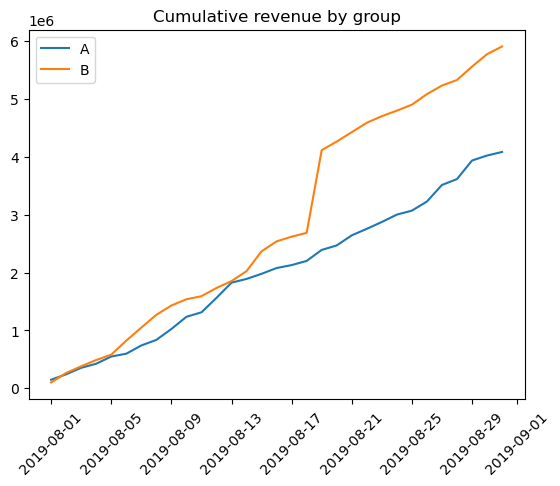

In [7]:
# plot the cumulative revenue for group A
plt.plot(data['date'], data['revenue_cumulative_A'], label='A')

# plot the cumulative revenue for group B
plt.plot(data['date'], data['revenue_cumulative_B'], label='B')

# rotate x-axis labels for readability
plt.xticks(rotation=45)

# set the plot title and adds a legend
plt.title('Cumulative revenue by group')
plt.legend()

# display the plot
plt.show()


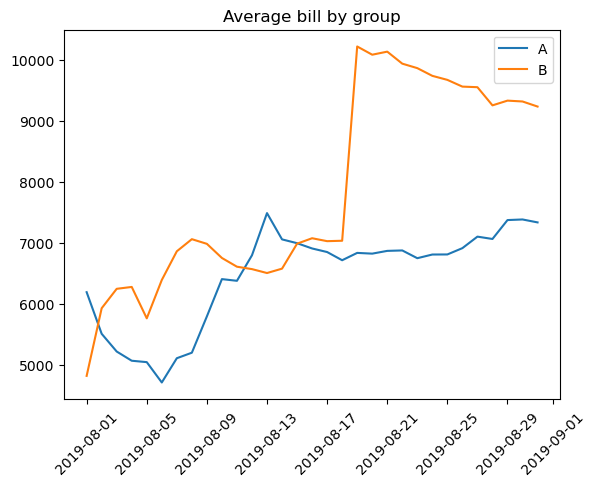

In [8]:
# plot the average bill for group A by dividing cumulative revenue by cumulative orders
plt.plot(data['date'], data['revenue_cumulative_A'] / data['orders_cumulative_A'], label='A')

# plot the average bill for group B by dividing cumulative revenue by cumulative orders
plt.plot(data['date'], data['revenue_cumulative_B'] / data['orders_cumulative_B'], label='B')

# rotate x-axis labels for readability
plt.xticks(rotation=45)

# sets the plot title and adds a legend
plt.title('Average bill by group')
plt.legend()

# displays the plot
plt.show()


Both cumulative revenue and average bill graphs represent significant growth in B group by the end of the third week of August 2019. After the sharp spike in revenues the B group average bill steadily declines by the end of the observable period.

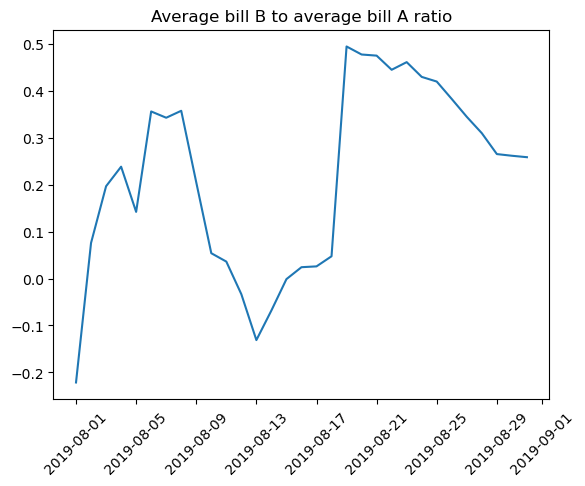

In [9]:
# calculate the ratio of average bill for group B to average bill for group A
ratio = (data['revenue_cumulative_B'] / data['orders_cumulative_B']) \
         / (data['revenue_cumulative_A'] / data['orders_cumulative_A']) - 1

# create a line plot of the ratio over time
plt.plot(data['date'], ratio)

# rotate x-axis labels for better readability
plt.xticks(rotation=45)

# add a title to the plot
plt.title('Average bill B to average bill A ratio')

# display the plot
plt.show()


The relationship between average bill ratios represent large increases of the B group's metric in the first and third weeks of the month (especially in the third week). This means that individual large purchases were made in group B during the observed period. Such events are considered to be outliers and should be eliminated in the further analysis.

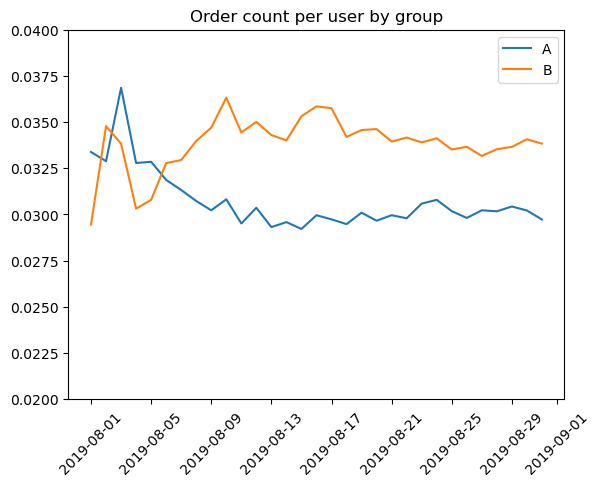

In [10]:
# plot the order count per user for group A and group B over time
plt.plot(data['date'], data['orders_cumulative_A'] / data['visitors_cumulative_A'], label='A')
plt.plot(data['date'], data['orders_cumulative_B'] / data['visitors_cumulative_B'], label='B')

# rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# add a title to the plot
plt.title('Order count per user by group')

# set the y-axis limits to better highlight the differences between the groups
plt.ylim(0.02, 0.04)

# add a legend to the plot
plt.legend()

# display the plot
plt.show()

Group B order counts exceeded the ones of group A in the beginning of the month. Afterwards, the order count per user stabilized around the values of 0.03 (group A) and 0.035 (group B).

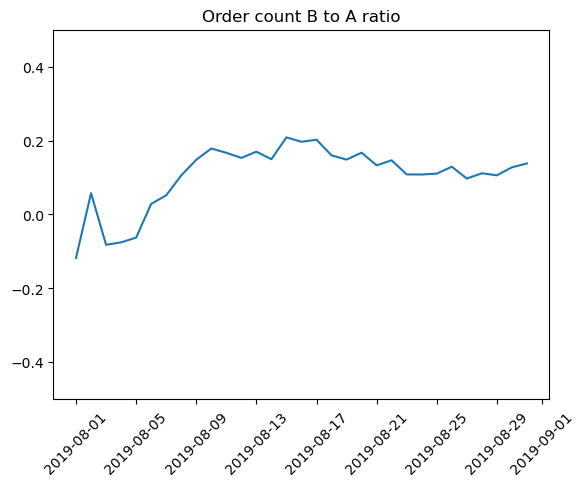

In [11]:
# plot the ratio of orders per visitor in group B to group A over time
plt.plot(data['date'], ((data['orders_cumulative_B'] / data['visitors_cumulative_B']) \
         / (data['orders_cumulative_A'] / data['visitors_cumulative_A'])) - 1)

# set x-axis labels to be rotated for better readability
plt.xticks(rotation=45)

# add a title to the plot
plt.title('Order count B to A ratio')

# set the y-axis limits to zoom in on the relevant range
plt.ylim(-0.5, 0.5)

# display the plot
plt.show()

The ratio of cumulative order counts (B to A) rises smoothly during the first half of August and fluctuates evenly thereafter.

### Step 4. Identifying outliers

In [12]:
# group orders by visitorId and aggregate number of unique transactions and total revenue
orders_by_user = orders.groupby('visitorId', as_index=False).agg({
    'transactionId': 'nunique', 'revenue': 'sum'
})

# rename columns for clarity
orders_by_user.columns = ['visitor', 'order_count', 'revenue_per_user']

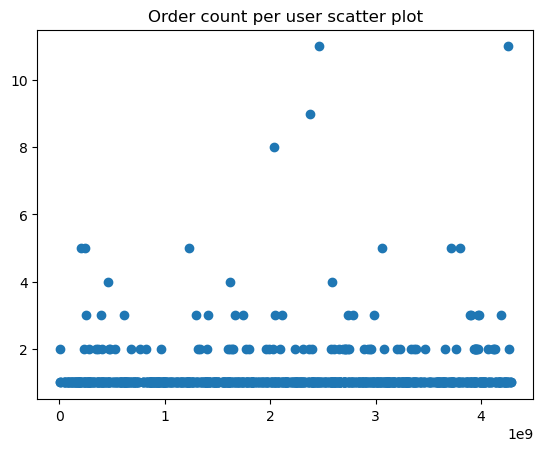

In [13]:
# scatter plot of order count per user
plt.scatter(orders_by_user['visitor'], orders_by_user['order_count'])

# set title
plt.title('Order count per user scatter plot')

# show the plot
plt.show()

In [14]:
# calculate the 90th, 95th, and 99th percentiles of the order count
order_count_percentile = np.percentile(orders_by_user['order_count'], [90, 95, 99])
order_count_percentile

array([1., 2., 4.])

95% of all orders per user fall in the interval of 1-2 purchases. Hence more than two orders per customer are rare and should be further filtered in order not to distort the A/B test results.

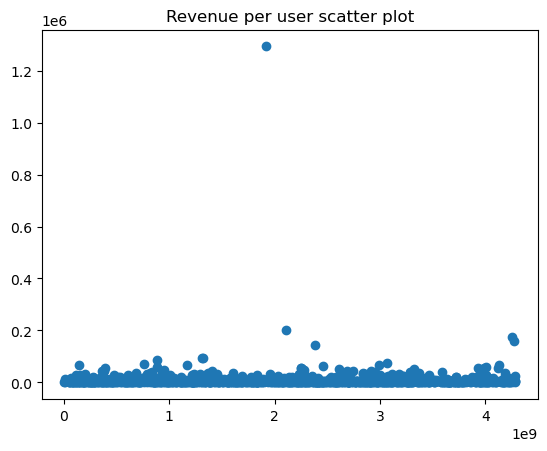

In [15]:
# create a scatter plot of revenue per user against visitor ID
plt.scatter(orders_by_user['visitor'], orders_by_user['revenue_per_user'])

# add a title to the plot
plt.title('Revenue per user scatter plot')

# show the plot
plt.show()

In [16]:
# calculate the 90th, 95th, and 99th percentiles of the revenue per user
revenue_percentile = np.percentile(orders_by_user['revenue_per_user'], [90, 95, 99])
revenue_percentile

array([19260. , 32899.5, 67750. ])

90% of all revenue per user does not exceed 19,260 units with larger orders considered to be outliers.

### Step 5. Testing data distribution normality

In [17]:
# set significance level
alpha = .05

# calculate number of orders per user for group A
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

# calculate number of orders per user for group B
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

# create a sample of order counts for group A
sample_order_count_A = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_A'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# create a sample of order counts for group B
sample_order_count_B = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_B'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# create a sample of average bill for group A
sample_avg_bill_A = orders[orders['group']=='A']['revenue']

# create a sample of average bill for group B
sample_avg_bill_B = orders[orders['group']=='B']['revenue']


In [18]:
def shapiro_test(sample):
    """
    This method takes in a sample as an input and performs a Shapiro-Wilk normality test
    on it using the shapiro() function from the scipy.stats library.
    The resulting p-value is printed out, and based on the significance level
    set as alpha earlier in the code, the function prints whether to reject or
    fail to reject the null hypothesis that the data distribution is normal.
    """
    p_value = st.shapiro(sample)[1]
    print('p-value: ', p_value)
    if p_value < alpha:
        print('Reject the null hypothesis: data distribution is not normal')
    else:
        print('Fail to reject the null hypothesis: data distribution not normal') 

In [19]:
# use shapiro_test method to test distribution
# normality for group A order count
shapiro_test(sample_order_count_A)

p-value:  0.0
Reject the null hypothesis: data distribution is not normal


C:\Users\pablo\anaconda3\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [20]:
# use shapiro_test method to test distribution
# normality for group B order count
shapiro_test(sample_order_count_B)

p-value:  0.0
Reject the null hypothesis: data distribution is not normal


In [21]:
# use shapiro_test method to test distribution
# normality for group A average bill
shapiro_test(sample_avg_bill_A)

p-value:  1.739723833199812e-34
Reject the null hypothesis: data distribution is not normal


In [22]:
# use shapiro_test method to test distribution
# normality for group B average bill
shapiro_test(sample_avg_bill_B)

p-value:  0.0
Reject the null hypothesis: data distribution is not normal


Hence all data distributions are not normal the Mann-Whitney non parametric test will be used to test whether two samples (A and B) are likely to derive from the same population.

### Step 6. Raw data order count Mann-Whitney test

In [23]:
# calculate the p-value for the Mann-Whitney U test
p_value_order_cnt_raw = st.mannwhitneyu(sample_order_count_A, sample_order_count_B)[1]

# print the p-value with 3 decimal places
print("p-value: {0:.3f}".format(p_value_order_cnt_raw))

# calculate the ratio of average order counts in group B to group A
avg_order_count_ratio = sample_order_count_B.mean() / sample_order_count_A.mean() - 1

# print the ratio of average order counts in group B to group A with 3 decimal places
print("avg B to avg A ratio: {0:.3f}".format(avg_order_count_ratio))

# check if the p-value is less than the significance level alpha
if p_value_order_cnt_raw < alpha:
    # if the p-value is less than alpha, reject the null hypothesis and print the corresponding message
    print('Reject H0: no difference between orders counts in groups A and B')
else:
    # if the p-value is not less than alpha, fail to reject the null hypothesis and print the corresponding message
    print('Fail to reject H0, H1: the metric in groups A and B differs.')

p-value: 0.017
avg B to avg A ratio: 0.138
Reject H0: no difference between orders counts in groups A and B


The null hypothesis: there is no difference between orders counts in groups A and B. The alternative hypothesis is: the metric in groups A and B differs.

The resulting p-value (the smallest significance level at which the null hypothesis can be rejected) of 1,7% is less than required 5% significance level. Therefore, there is stitistical evidence to reject the null hypothesis. The amount of purchases per 1 visitor do differ in groups A and B. The average amount of purchases in group B exceeds the other category by 13.8%.

### Step 7. Raw data average bill Mann-Whitney test.

In [24]:
# perform Mann-Whitney U test to compare the means of two groups
p_value_revenue_raw = st.mannwhitneyu(sample_avg_bill_A, sample_avg_bill_B)[1]

# print the p-value with three decimal places
print('p-value: {0:.3f}'.format(p_value_revenue_raw))

# calculate the ratio of average revenue in group B to group A, and print with three decimal places
print('avg B to avg A ratio: {0:.3f}'.format(sample_avg_bill_B.mean()/sample_avg_bill_A.mean()-1))

# check the p-value against the significance level alpha
if p_value_revenue_raw < alpha:
    # reject the null hypothesis if p-value is less than alpha
    print('Reject H0: no difference between average bills in groups A and B')
else:
    # fail to reject the null hypothesis if p-value is greater than or equal to alpha
    print('Fail to reject H0, H1: the metric in groups A and B differs')

p-value: 0.729
avg B to avg A ratio: 0.259
Fail to reject H0, H1: the metric in groups A and B differs


The null hypothesis: there is no difference between average bills in groups A and B. The alternative hypothesis is: the metric in groups A and B differs.

The resulting p-value of 72,9% exceeds 5% significance level. Therefore, there the rejection the null hypothesis is failed. There is no statistical evidence in favor of difference between average bills in groups A and B even though on average the B group bills are 25,9% higher comparing to group A.

### Step 8. Filtering data

In [25]:
# select users with more orders than the 95th percentile
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > order_count_percentile[1]]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > order_count_percentile[1]]['visitorId'],
    ],
    axis=0,
)

# select users with order revenue higher than the 90th percentile
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_percentile[0]]['visitorId']

# combine the two sets of users and remove duplicates to obtain the set of abnormal users
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# print the first 5 abnormal user IDs
print(abnormalUsers.head(5))

# print the total number of abnormal users
print(abnormalUsers.shape[0])


568     113298937
1099    148427295
461     154576532
18      199603092
928     204675465
Name: visitorId, dtype: int64
107


In [26]:
# Filter out users with an abnormally high number of orders or expensive orders
usersWithManyOrders = pd.concat(
    [        ordersByUsersA[ordersByUsersA['orders'] > order_count_percentile[1]]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > order_count_percentile[1]]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > revenue_percentile[0]]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

# Filter out orders made by abnormal users
sampleAFiltered = pd.concat(
    [        ordersByUsersA[ np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_A'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [        ordersByUsersB[ np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitors_per_day_B'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


The abnormal data was filtered in order to reperform the Mann-Whitney statistical test.

### Step 9. Filtered data order count Mann-Whitney test

In [27]:
# calculate the p-value for the filtered samples using Mann-Whitney U test
p_value_order_cnt = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

# print the p-value
print("p-value: {0:.3f}".format(p_value_order_cnt_raw))

# print the average B to average A ratio for the filtered samples
print("avg B to avg A ratio: {0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

# check if the p-value is less than the significance level (alpha)
# and print the corresponding conclusion
if p_value_order_cnt_raw < alpha:
    print('Reject H0: no difference between orders counts in groups A and B')
else:
    print('Fail to reject H0, H1: the metric in groups A and B differs')

p-value: 0.017
avg B to avg A ratio: 0.163
Reject H0: no difference between orders counts in groups A and B


### Step 10. Filtered data average bill Mann-Whitney test

In [28]:
# calculate the p-value for the Mann-Whitney U test on the filtered samples
p_value_revenue = st.mannwhitneyu(
            orders[np.logical_and(orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[np.logical_and(orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]

# print the calculated p-value with a precision of 3 decimal places
print('p-value: {0:.3f}'.format(p_value_revenue))

# calculate and print the ratio of the mean revenue of group B to group A
print("avg B to avg A ratio: {0:.3f}".format(
        orders[np.logical_and(orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[np.logical_and(orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

# check if the p-value is less than the significance level alpha, and print the result
if p_value_revenue < alpha:
    print('Reject H0: no difference between average bills in groups A and B')
else:
    print('Fail to reject H0, H1: the metric in groups A and B differs')

p-value: 0.517
avg B to avg A ratio: -0.060
Fail to reject H0, H1: the metric in groups A and B differs


The results of hypothesis testing remain unchanged: we reject the null hypothesis of order counts equality and fail to reject the null hypothesis of the average bill equality in groups A and B. Although, the filtered data no longer represents any difference between the mean values of the average bills in the observable groups (the ratio of -6% comparing to 25,9% in the raw data).

### Step 11. General conclusion

To sum up, the results of the A/B test are:

- there is statistically significant difference in the orders amount between the groups judging by both raw and filtered data;
- there is no statistically significant difference in the average bill between the groups judging by both raw and filtered data;
- the orders count of the B group are on average from 13.8% (raw data) to 16.3% (filtered data) larger comparing to the control group;
- cumulative order count graph showed that group B order counts exceeded the ones of group A in the beginning of August 2019 and stabilized around the values of 0.03 (group A) and 0.035 (group B).

Due to the above mentioned conclusions new recommendation system proved to be effective in terms of orders volume, the A/B test should be admitted successful, B group should be considered as the winner.